# Step 1 
## download the data of a index of your choosing and split into training and testing datasets

In [1]:
from AntFolio import download_data, get_tickers, train_test_split, get_pct_returns, get_cum_returns, get_log_returns, transform_to_uniform, benchmark_equal_weights, portfolio_pct_returns, portfolio_cum_returns, portfolio_log_returns, plot_cumulative_returns_portfolio, combine_cumulative_returns

ticker_df = get_tickers('nasdaq100')
data, updated_tickers_df = download_data(ticker_df, '2020-01-01', '2021-01-01')
train, test = train_test_split(data, train_start='2020-01-01', train_end='2020-12-01', test_start='2020-12-01', test_end='2021-01-01')

[*********************100%***********************]  107 of 107 completed

2024-05-29 15:19:15,420 - ERROR - 
6 Failed downloads:
2024-05-29 15:19:15,421 - ERROR - ['GEHC', 'GFS', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1609477200")
2024-05-29 15:19:15,422 - ERROR - ['NQM4', 'MLIFT']: Exception('%ticker%: No timezone found, symbol may be delisted')
2024-05-29 15:19:15,423 - ERROR - ['CAD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2021-01-01)')


2024-05-29 15:19:15,614 - INFO - Tickers identified for removal due to download failures: ['GEHC', 'NQM4', 'CAD', 'GFS', 'CEG', 'MLIFT']
2024-05-29 15:19:15,793 - INFO - From the initial 108 tickers, 101 were successfully downloaded and retained.


# Step 2
## Create your custom portfolio optimizaiton model and get your weights

In [2]:
print(len(updated_tickers_df['symbol']))
print(len(train['Adj Close'].columns))

uptick_list = updated_tickers_df['symbol'].to_list()
train_tickers = train['Adj Close'].columns.to_list()

# sort the lists
uptick_list.sort()
train_tickers.sort()

print(len(uptick_list))
print(len(train_tickers))   

for row in range(len(uptick_list)):
    print(uptick_list[row], train_tickers[row])

# what is the ticker that is not in the train data
missing_ticker = [x for x in uptick_list if x not in train_tickers]
print(missing_ticker)


101
101
101
101
AAPL AAPL
ABNB ABNB
ADBE ADBE
ADI ADI
ADP ADP
ADSK ADSK
AEP AEP
AMAT AMAT
AMD AMD
AMGN AMGN
AMZN AMZN
ANSS ANSS
ASML ASML
AVGO AVGO
AZN AZN
BIIB BIIB
BKNG BKNG
BKR BKR
CCEP CCEP
CDNS CDNS
CDW CDW
CHTR CHTR
CMCSA CMCSA
COST COST
CPRT CPRT
CRWD CRWD
CSCO CSCO
CSGP CSGP
CSX CSX
CTAS CTAS
CTSH CTSH
DASH DASH
DDOG DDOG
DLTR DLTR
DXCM DXCM
EA EA
EUR EUR
EXC EXC
FANG FANG
FAST FAST
FTNT FTNT
GBP GBP
GILD GILD
GOOG GOOG
GOOGL GOOGL
HON HON
IDXX IDXX
ILMN ILMN
INTC INTC
INTU INTU
ISRG ISRG
KDP KDP
KHC KHC
KLAC KLAC
LIN LIN
LRCX LRCX
LULU LULU
MAR MAR
MCHP MCHP
MDB MDB
MDLZ MDLZ
MELI MELI
META META
MNST MNST
MRNA MRNA
MRVL MRVL
MSFT MSFT
MU MU
NFLX NFLX
NVDA NVDA
NXPI NXPI
ODFL ODFL
ON ON
ORLY ORLY
PANW PANW
PAYX PAYX
PCAR PCAR
PDD PDD
PEP PEP
PYPL PYPL
QCOM QCOM
REGN REGN
ROP ROP
ROST ROST
SBUX SBUX
SIRI SIRI
SNPS SNPS
TEAM TEAM
TMUS TMUS
TSLA TSLA
TTD TTD
TTWO TTWO
TXN TXN
USD USD
VRSK VRSK
VRTX VRTX
WBA WBA
WBD WBD
WDAY WDAY
XEL XEL
ZS ZS
[]


In [3]:
from scipy.optimize import minimize
import numpy as np

def markowitz_optimization(train, updated_tickers_df, risk_free_rate=0.02):

    cov_matrix = train.cov()
    mean_returns = train.mean()
    num_assets = len(updated_tickers_df)

    def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
        returns = np.sum(mean_returns * weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (returns - risk_free_rate) / volatility
        return returns, volatility, sharpe_ratio

    def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]

    result = minimize(negative_sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x

    return optimal_weights

pct_returns = get_pct_returns(train)
optimal_weights = markowitz_optimization(pct_returns, updated_tickers_df['symbol'].to_list()) 

# Step 2
## Backtest the results on the testing dataset and compare to the benchmark (equally weighted portfolio)

    symbol                         name                   sector
0     MSFT               MICROSOFT CORP   Information Technology
1     AAPL                    APPLE INC   Information Technology
2     NVDA                  NVIDIA CORP   Information Technology
3     AMZN               AMAZON COM INC   Consumer Discretionary
4     AVGO                 BROADCOM INC   Information Technology
..     ...                          ...                      ...
96     WBA  WALGREEN BOOTS ALLIANCE INC         Consumer Staples
97    SIRI       SIRIUS XM HOLDINGS INC            Communication
98     USD                     USD CASH  Cash and/or Derivatives
100    EUR                     EUR CASH  Cash and/or Derivatives
101    GBP                     GBP CASH  Cash and/or Derivatives

[101 rows x 3 columns]


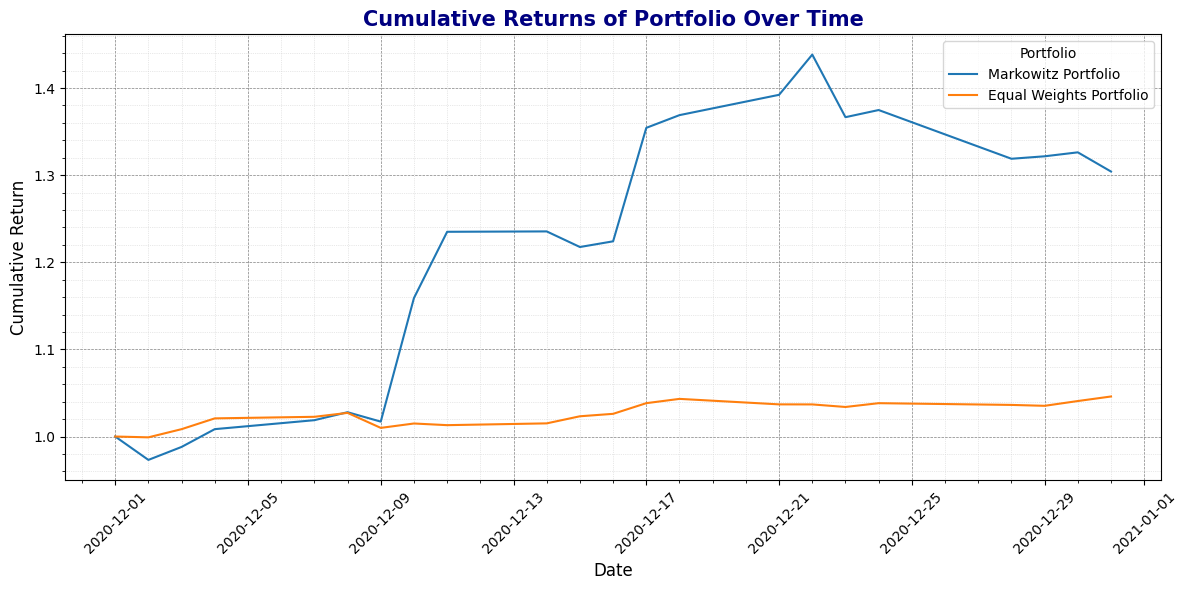

In [4]:
print(updated_tickers_df)

equal_weights = benchmark_equal_weights(updated_tickers_df)

markowitz_cum_returns = portfolio_cum_returns(test, updated_tickers_df, optimal_weights)
equal_weights_cum_returns = portfolio_cum_returns(test, updated_tickers_df, equal_weights)

cum_retu_backtest = combine_cumulative_returns(markowitz_cum_returns, equal_weights_cum_returns, portfolio_names=['Markowitz Portfolio', 'Equal Weights Portfolio'])
plot_cumulative_returns_portfolio(cum_retu_backtest)